# Проект 2.
## Изученить воронку, провести А/В-тест в связи с внедрением новой рекомендательной системы.

## Цель: проверить новую воронку - изменение конверсии на всех этапах, в связи с внедрением новой рекомендательной системы, согласно ТЗ. Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%


### Описание данных:
- датафрейм: календарь маркетинговых событий на 2020 год;
- датафрейм: пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года;
- датафрейм: действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
- датафрейм: участники тестов тестов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from datetime import datetime
from scipy import stats as st
import math as mth
import warnings

In [2]:
warnings.filterwarnings('ignore') 

In [3]:
try:
    marketing_events = pd.read_csv(
    '/Users/sergejnitkin/Final_project/АВ тест финальный проект/ab_project_marketing_events.csv', 
    parse_dates=['start_dt', 'finish_dt']) # сразу спарсим даты
except:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv', 
                                   parse_dates=['start_dt', 'finish_dt'])
marketing_events

name                   regions   start_dt  \
0           Christmas&New Year Promo             EU, N.America 2020-12-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2             St. Patric's Day Promo             EU, N.America 2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
4                  4th of July Promo                 N.America 2020-07-04   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America 2020-11-26   
6             Chinese New Year Promo                      APAC 2020-01-25   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC 2020-05-01   
8    International Women's Day Promo             EU, CIS, APAC 2020-03-08   
9    Victory Day CIS (May 9th) Event                       CIS 2020-05-09   
10         CIS New Year Gift Lottery                       CIS 2020-12-30   
11     Dragon Boat Festival Giveaway                      APAC 2020-06-25   
12           Single's Day Gift Promo                      APAC 2020-11-11   
13             Chinese Moon Festival                      APAC 2020-10-01   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
5  2020-12-01  
6  2020-02-07  
7  2020-05-03  
8  2020-03-10  
9  2020-05-11  
10 2021-01-07  
11 2020-07-01  
12 2020-11-12  
13 2020-10-07

In [4]:
marketing_events.info() # смотрим на пропуски и типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


#### Тут видим, что одна из промоакций попадает на период проведения нашего теста. Вернемся позже к этому, тк я думаю, что акция имела равное влияние на обе группы.

In [5]:
try:
    new_users = pd.read_csv(
   '/Users/sergejnitkin/Final_project/АВ тест финальный проект/final_ab_new_users.csv', parse_dates = ['first_date'])
except:
     new_users = pd.read_csv(
   '/datasets/final_ab_new_users.csv', parse_dates = ['first_date'])
new_users

user_id first_date     region   device
0      D72A72121175D8BE 2020-12-07         EU       PC
1      F1C668619DFE6E65 2020-12-07  N.America  Android
2      2E1BF1D4C37EA01F 2020-12-07         EU       PC
3      50734A22C0C63768 2020-12-07         EU   iPhone
4      E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone
...                 ...        ...        ...      ...
61728  1DB53B933257165D 2020-12-20         EU  Android
61729  538643EB4527ED03 2020-12-20         EU      Mac
61730  7ADEE837D5D8CBBD 2020-12-20         EU       PC
61731  1C7D23927835213F 2020-12-20         EU   iPhone
61732  8F04273BB2860229 2020-12-20         EU  Android

[61733 rows x 4 columns]

In [6]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [7]:
new_users.duplicated().sum()

0

In [8]:
display(new_users['region'].unique())
display(new_users['device'].unique())

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [9]:
try:
    events = pd.read_csv(
    '/Users/sergejnitkin/Final_project/АВ тест финальный проект/final_ab_events.csv', parse_dates = ['event_dt'])
except:
    events = pd.read_csv(
    '/datasets/final_ab_events.csv', parse_dates = ['event_dt'])
events

user_id            event_dt event_name  details
0       E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase    99.99
1       7B6452F081F49504 2020-12-07 09:22:53   purchase     9.99
2       9CD9F34546DF254C 2020-12-07 12:59:29   purchase     4.99
3       96F27A054B191457 2020-12-07 04:02:40   purchase     4.99
4       1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase     4.99
...                  ...                 ...        ...      ...
440312  245E85F65C358E08 2020-12-30 19:35:55      login      NaN
440313  9385A108F5A0A7A7 2020-12-30 10:54:15      login      NaN
440314  DB650B7559AC6EAC 2020-12-30 10:59:09      login      NaN
440315  F80C9BDDEA02E53C 2020-12-30 09:53:39      login      NaN
440316  7AEC61159B672CC5 2020-12-30 11:36:13      login      NaN

[440317 rows x 4 columns]

In [10]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [11]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [12]:
events.duplicated().sum()

0

In [13]:
try:
    test_users = pd.read_csv('/Users/sergejnitkin/Final_project/АВ тест финальный проект/final_ab_participants.csv')
except:
    test_users = pd.read_csv('/datasets/final_ab_participants.csv')
test_users

user_id group                  ab_test
0      D1ABA3E2887B6A73     A  recommender_system_test
1      A7A3664BD6242119     A  recommender_system_test
2      DABC14FDDFADD29E     A  recommender_system_test
3      04988C5DF189632E     A  recommender_system_test
4      482F14783456D21B     B  recommender_system_test
...                 ...   ...                      ...
18263  1D302F8688B91781     B        interface_eu_test
18264  3DE51B726983B657     A        interface_eu_test
18265  F501F79D332BE86C     A        interface_eu_test
18266  63FBE257B05F2245     A        interface_eu_test
18267  79F9ABFB029CF724     B        interface_eu_test

[18268 rows x 3 columns]

In [14]:
test_users.info() # смотрим на пропуски и типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [15]:
test_users.duplicated().sum() # ищем задвоения

0

In [16]:
test_users['ab_test'].unique() # посмотрим на количество проводимых АВ тестов

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

#### теста 2. посмотрим на пересечения

In [17]:
display
(
    'Количество пользователей, участвующих в обоих тестах: {}'
    .format(
        test_users[test_users['ab_test']=='recommender_system_test']['user_id']
        .isin(test_users[test_users['ab_test']=='interface_eu_test']['user_id'])
            .count()
           )
)

'Количество пользователей, участвующих в обоих тестах: 6701'

#### Тут есть пересечения тестов на наших пользователях, посмотрим подробнее

In [18]:
display
('Количество пользователей теста recommender_system_test: {}'
 .format(test_users[test_users['ab_test'] == 'recommender_system_test']['user_id'].count())
)

'Количество пользователей теста recommender_system_test: 6701'

#### получается, что все наши испытуемые принимали участие и вдругом тесте. нужно понять влияние того теста на наш. посмотрим на состав 

In [19]:
first_test = test_users.query('ab_test == "recommender_system_test"')
second_test_b_group = test_users.query('(ab_test == "interface_eu_test") & (group == "B")').user_id.unique()
critical_users = first_test.query('user_id in @second_test_b_group').user_id
critical_users.count()

783

#### то есть у нас получается, что 783 (11,6%) юзера принимали участи в группе В второго теста и видели измененный интерфейс

In [20]:
filtered_users = first_test.query('user_id not in @critical_users')
filtered_users.user_id.count()

5918

#### таким образом мы оставили 5918 участников теста. теперь посмотрим на распределение по группам

In [21]:
display('Количество участников в группе А: {}'.format(filtered_users.query('group == "A"').user_id.count()))
display('Количество участников в группе B: {}'.format(filtered_users.query('group == "B"').user_id.count()))

'Количество участников в группе А: 3385'

'Количество участников в группе B: 2533'

In [22]:
display('Количество участников в группе А: {}'.format(first_test.query('group == "A"').user_id.count()))
display('Количество участников в группе B: {}'.format(first_test.query('group == "B"').user_id.count()))

'Количество участников в группе А: 3824'

'Количество участников в группе B: 2877'

####  После фильтрации я заметил, что кол-во пользователей в равных пропорциях распределялись по А и В группе нашего теста, поэтому думаю, что влияние было равномерное и луше все же сохранить этих пользователей, тк чем больше данных, тем точнее оценка

In [23]:
display('Количество участников в обоих группах: {}'.format(first_test.query('(group == "A") & (group == "B")')
                                             .user_id.count()))

'Количество участников в обоих группах: 0'

#### Что касается маркетинговых акций, то мы пересекаемся с одной, но поскольку она раскатывается на всех пользователей региона EU, то думаю, что будет иметь одинаковое влияние на обе группы нашего теста. 

#### теперь отфильтруем только пользователей нашего теста.

In [24]:
new_users_good = new_users.merge(first_test, on='user_id', how='left').dropna(subset=['group'], axis=0).drop(columns=['ab_test', 'device'])
display(new_users_good['user_id'].count())
new_users_good.sample(10, random_state=0)

6701

user_id first_date region group
14062  17CF81D53CAD4035 2020-12-21     EU     B
38097  58762DB8BD8A7A05 2020-12-17     EU     A
19334  3814144B81D16E96 2020-12-08     EU     B
3642   7C467B7392723B31 2020-12-07     EU     A
44438  3E342E66B94594CB 2020-12-18     EU     B
22904  B0CC8803631848A0 2020-12-15     EU     B
59600  1BE3717DF3A38FBF 2020-12-20     EU     A
46040  86B91078B1F0BA1A 2020-12-12     EU     A
35545  506686F95FE5FBE8 2020-12-10     EU     B
33967  55B29FDA9690315B 2020-12-10     EU     B

#### проверим данные на соответствие ТЗ, а именно регион должен бы EU.

In [25]:
new_users_good['region'].unique()

array(['EU', 'APAC', 'CIS', 'N.America'], dtype=object)

#### теперь избавимся от лишнего, оставим только пользователей из Европы

In [26]:
new_users_good = new_users_good[new_users_good['region'] == 'EU']
new_users_good['user_id'].count()

6351

#### проверим, чтобы даты регистрации пользователей совпадали с ТЗ

In [27]:
display('Дата начала регистрации юзеров: {}'.format(new_users_good['first_date'].min()))
display('Дата окончания регистрации юзеров: {}'.format(new_users_good['first_date'].max()))

'Дата начала регистрации юзеров: 2020-12-07 00:00:00'

'Дата окончания регистрации юзеров: 2020-12-21 00:00:00'

#### Даты набора юзеров для теста соответствуют ТЗ

#### Теперь надо отфильтровать события только по тем юзерам, которые участвуют в нашем тесте, для этого объединим датафреймы и дропнем все лишнее

In [28]:
events_good = (events.merge(new_users_good, on='user_id', how='left')
               .dropna(subset=['group'], axis=0).drop(columns=['details'])
              )
events_good

user_id            event_dt event_name first_date region  \
5       831887FE7F2D6CBA 2020-12-07 06:50:29   purchase 2020-12-07     EU   
17      3C5DD0288AC4FE23 2020-12-07 19:42:40   purchase 2020-12-07     EU   
58      49EA242586C87836 2020-12-07 06:31:24   purchase 2020-12-07     EU   
71      2B06EB547B7AAD08 2020-12-07 21:36:38   purchase 2020-12-07     EU   
74      A640F31CAC7823A6 2020-12-07 18:48:26   purchase 2020-12-07     EU   
...                  ...                 ...        ...        ...    ...   
440239  D21F0D4FDCD82DB2 2020-12-29 02:17:00      login 2020-12-20     EU   
440258  96BDD55846D1F7F6 2020-12-29 16:53:42      login 2020-12-20     EU   
440267  553BAE96C6EB6240 2020-12-29 14:09:14      login 2020-12-20     EU   
440281  DD4352CDCF8C3D57 2020-12-30 12:42:56      login 2020-12-07     EU   
440289  75845C83258FBF73 2020-12-30 06:42:52      login 2020-12-07     EU   

       group  
5          A  
17         A  
58         B  
71         A  
74         B  
...      ...  
440239     A  
440258     A  
440267     A  
440281     B  
440289     B  

[23420 rows x 6 columns]

In [29]:
events_good['date'] = pd.to_datetime(events_good['event_dt']).dt.date #прикрутим дату к датафрейму
events_good

user_id            event_dt event_name first_date region  \
5       831887FE7F2D6CBA 2020-12-07 06:50:29   purchase 2020-12-07     EU   
17      3C5DD0288AC4FE23 2020-12-07 19:42:40   purchase 2020-12-07     EU   
58      49EA242586C87836 2020-12-07 06:31:24   purchase 2020-12-07     EU   
71      2B06EB547B7AAD08 2020-12-07 21:36:38   purchase 2020-12-07     EU   
74      A640F31CAC7823A6 2020-12-07 18:48:26   purchase 2020-12-07     EU   
...                  ...                 ...        ...        ...    ...   
440239  D21F0D4FDCD82DB2 2020-12-29 02:17:00      login 2020-12-20     EU   
440258  96BDD55846D1F7F6 2020-12-29 16:53:42      login 2020-12-20     EU   
440267  553BAE96C6EB6240 2020-12-29 14:09:14      login 2020-12-20     EU   
440281  DD4352CDCF8C3D57 2020-12-30 12:42:56      login 2020-12-07     EU   
440289  75845C83258FBF73 2020-12-30 06:42:52      login 2020-12-07     EU   

       group        date  
5          A  2020-12-07  
17         A  2020-12-07  
58         B  2020-12-07  
71         A  2020-12-07  
74         B  2020-12-07  
...      ...         ...  
440239     A  2020-12-29  
440258     A  2020-12-29  
440267     A  2020-12-29  
440281     B  2020-12-30  
440289     B  2020-12-30  

[23420 rows x 7 columns]

#### теперь проверим дату остановки теста - она должна быть 2021-01-04 согласно ТЗ

In [30]:
display('Дата последних событий: {}'.format(events_good['date'].max()))

'Дата последних событий: 2020-12-30'

#### таким образом получается, что согласно задаче исследования, я должен отсечь всех пользователей, которые прожили меньше 14 дней, то есть оставить только тех, кто зарегистрировался до 17 включительно.

In [31]:
events_good_filtered = events_good[events_good['first_date'] <= '2020-12-17']
events_good_filtered

user_id            event_dt event_name first_date region  \
5       831887FE7F2D6CBA 2020-12-07 06:50:29   purchase 2020-12-07     EU   
17      3C5DD0288AC4FE23 2020-12-07 19:42:40   purchase 2020-12-07     EU   
58      49EA242586C87836 2020-12-07 06:31:24   purchase 2020-12-07     EU   
71      2B06EB547B7AAD08 2020-12-07 21:36:38   purchase 2020-12-07     EU   
74      A640F31CAC7823A6 2020-12-07 18:48:26   purchase 2020-12-07     EU   
...                  ...                 ...        ...        ...    ...   
439346  69924C768EE3374C 2020-12-29 23:27:00      login 2020-12-12     EU   
439774  016F758EB5C5A5DA 2020-12-29 07:51:00      login 2020-12-13     EU   
439809  7DC0F01827866E41 2020-12-29 08:43:44      login 2020-12-13     EU   
440281  DD4352CDCF8C3D57 2020-12-30 12:42:56      login 2020-12-07     EU   
440289  75845C83258FBF73 2020-12-30 06:42:52      login 2020-12-07     EU   

       group        date  
5          A  2020-12-07  
17         A  2020-12-07  
58         B  2020-12-07  
71         A  2020-12-07  
74         B  2020-12-07  
...      ...         ...  
439346     B  2020-12-29  
439774     A  2020-12-29  
439809     A  2020-12-29  
440281     B  2020-12-30  
440289     B  2020-12-30  

[14821 rows x 7 columns]

In [32]:
print('Итоговые размеры групп после фильтрации и приведения к требованиям ТЗ')
print('Участников в группе A: {}'.format(events_good_filtered.query('group == "A"').user_id.nunique()))
print('Участников в группе B: {}'.format(events_good_filtered.query('group == "B"').user_id.nunique()))

Итоговые размеры групп после фильтрации и приведения к требованиям ТЗ
Участников в группе A: 1515
Участников в группе B: 640


## ВЫВОД:
Итак, мы посмотрели на данные, обработали их и привели в соответствие с ТЗ.

## Исследовательский анализ

### Количество событий на пользователя одинаково распределены в выборках?

In [33]:
print('Распределение кол-ва событий на пользователя в группе А {}'
    .format(
        events_good_filtered[events_good_filtered['group'] == 'A'].groupby('user_id').agg({'event_dt': 'count'})
        .describe()
    )
)

Распределение кол-ва событий на пользователя в группе А           event_dt
count  1515.000000
mean      7.163696
std       3.907399
min       1.000000
25%       4.000000
50%       6.000000
75%       9.000000
max      24.000000


In [34]:
print('Распределение кол-ва событий на пользователя в группе B {}'
    .format(
        events_good_filtered[events_good_filtered['group'] == 'B'].groupby('user_id').agg({'event_dt': 'count'})
        .describe()
    )
)

Распределение кол-ва событий на пользователя в группе B          event_dt
count  640.000000
mean     6.200000
std      3.661413
min      1.000000
25%      4.000000
50%      6.000000
75%      8.000000
max     28.000000


Теперь сделаем график распределения, где по оси Х будет количество событий, по оси У - количество пользователей в разбивке по группам.

In [35]:
events_by_u = events_good_filtered.groupby('user_id').agg({'event_dt': 'count'}).reset_index()
events_by_u = events_by_u.merge(test_users, on='user_id', how='left').drop(columns='ab_test')
events_by_u

user_id  event_dt group
0     0010A1C096941592        12     A
1     003DF44D7589BBD4        15     A
2     00505E15A9D81546         5     A
3     006E3E4E232CE760         6     A
4     0082295A41A867B5        20     A
...                ...       ...   ...
2714  FF40F25452E70E3D         4     A
2715  FF4456FBA59116E3        12     A
2716  FFAE9489C76F352B         6     A
2717  FFF28D02B1EACBE1         9     B
2718  FFF28D02B1EACBE1         9     A

[2719 rows x 3 columns]

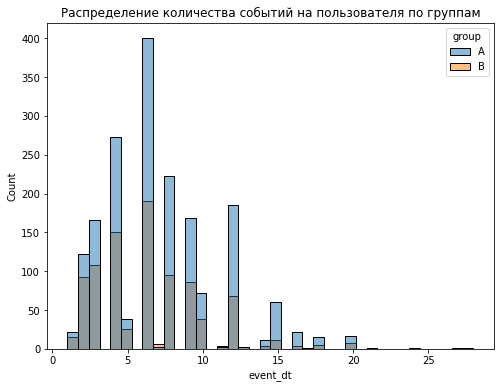

In [36]:
plt.figure(figsize=(8, 6))
plt.title('Распределение количества событий на пользователя по группам')
sns.histplot(data=events_by_u, x='event_dt', hue='group')
plt.show()

#### из анализа видно, что в среднем пользователи группы А в среднем совершали 7,16 действия, а пользователи из группы В 6,2 действия, в то время как медиана в обоих группах одинаковая - 6 событий, это может говорить о выбросах в группе А, хотя максимальное значение в В выше - 28 событий против 24. В целом на графиках видно, что пользователи А в общем более активны

### Как число событий в выборках распределено по дням?

In [37]:
print('Распределение кол-ва событий по дням в группе А {}'
    .format(
        events_good_filtered[events_good_filtered['group'] == 'A'].groupby('date').agg({'event_dt': 'count'})
        .describe()
    )
)

Распределение кол-ва событий по дням в группе А           event_dt
count    23.000000
mean    471.869565
std     305.977020
min     200.000000
25%     293.000000
50%     333.000000
75%     536.000000
max    1200.000000


In [38]:
events_by_date = events_good_filtered[events_good_filtered['group'] == 'A'].groupby('date', as_index=False).agg({'user_id': 'count'})
px.histogram(data_frame=events_by_date, x='date', y='user_id', nbins=24, title='Гистограмма распределения событий в группе А по дате')

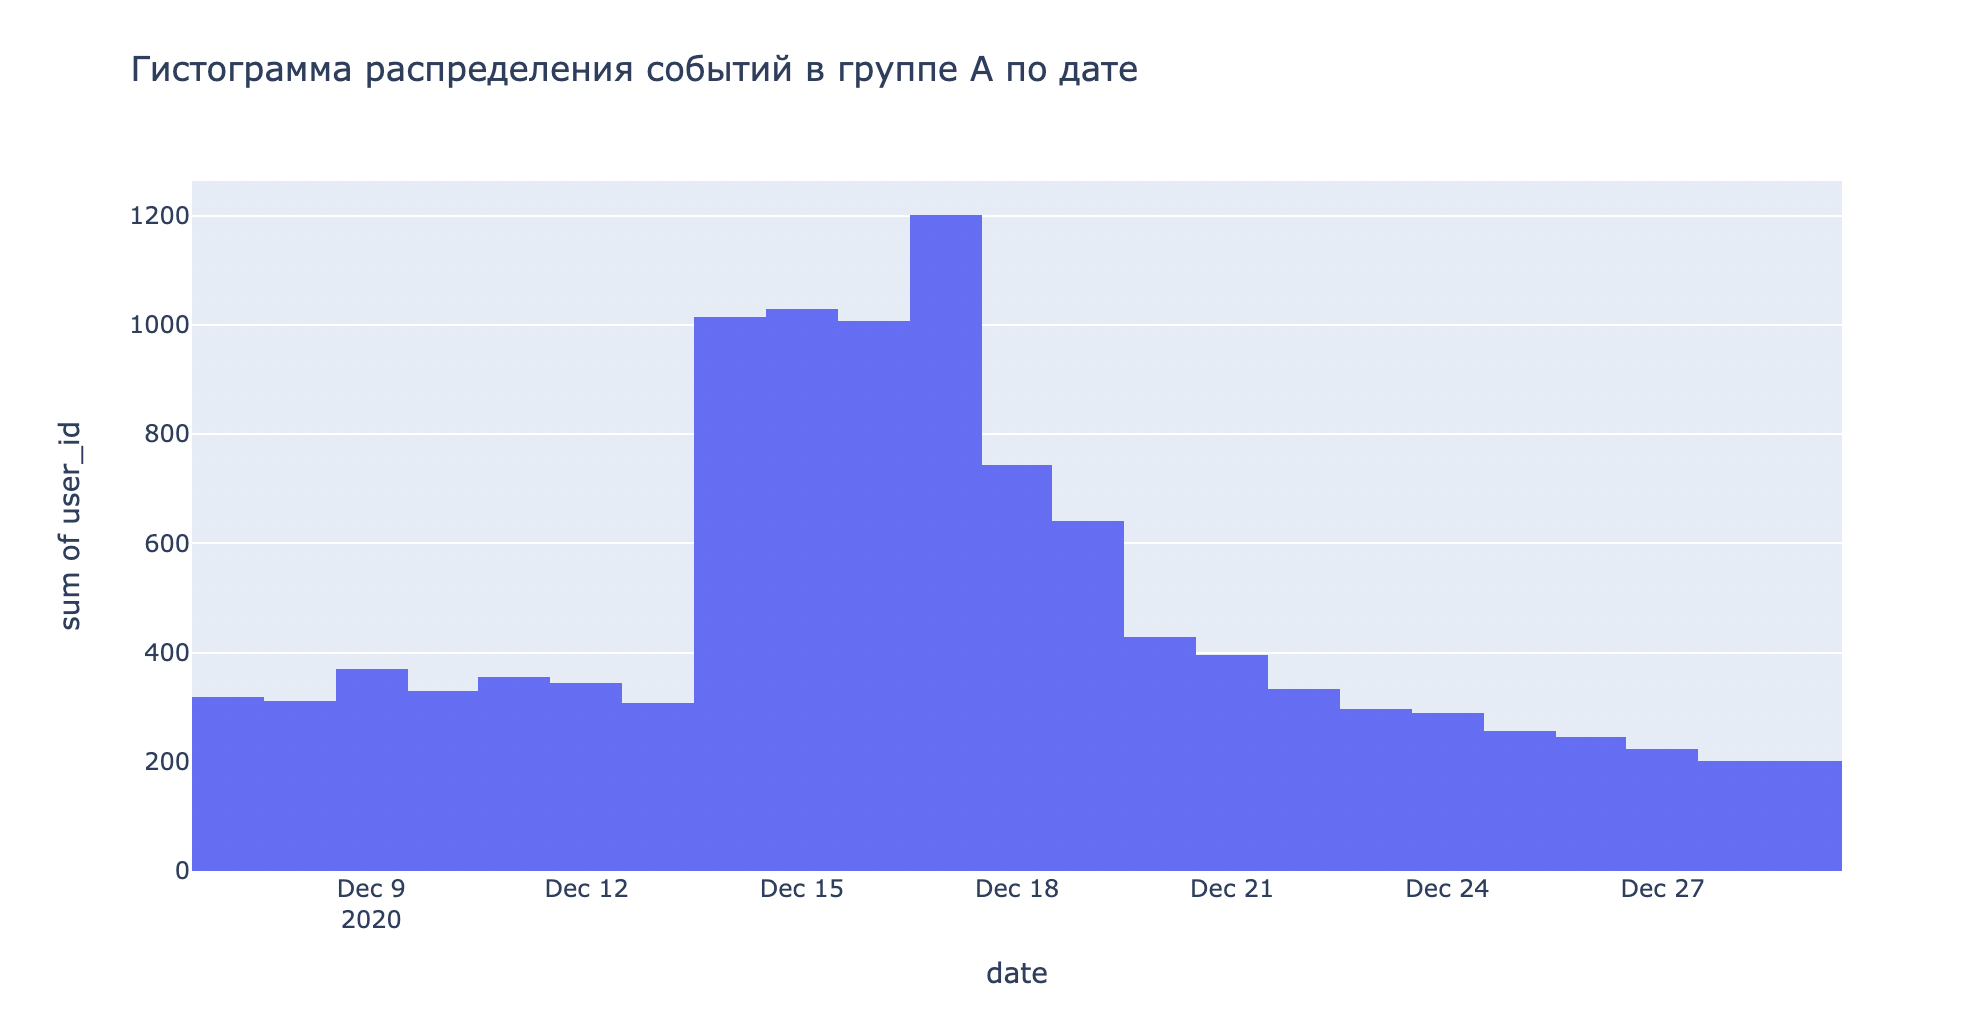

In [39]:
print('Распределение кол-ва событий по дням в группе B {}'
    .format(
        events_good_filtered[events_good_filtered['group'] == 'B'].groupby('date').agg({'event_dt': 'count'})
        .describe()
    )
)

Распределение кол-ва событий по дням в группе B          event_dt
count   24.000000
mean   165.333333
std    103.708482
min      4.000000
25%     73.000000
50%    161.500000
75%    240.500000
max    369.000000


In [40]:
events_by_date = events_good_filtered[events_good_filtered['group'] == 'B'].groupby('date', as_index=False).agg({'user_id': 'count'})
px.histogram(data_frame=events_by_date, x='date', y='user_id', nbins=24, title='Гистограмма распределения событий в группе B по дате')

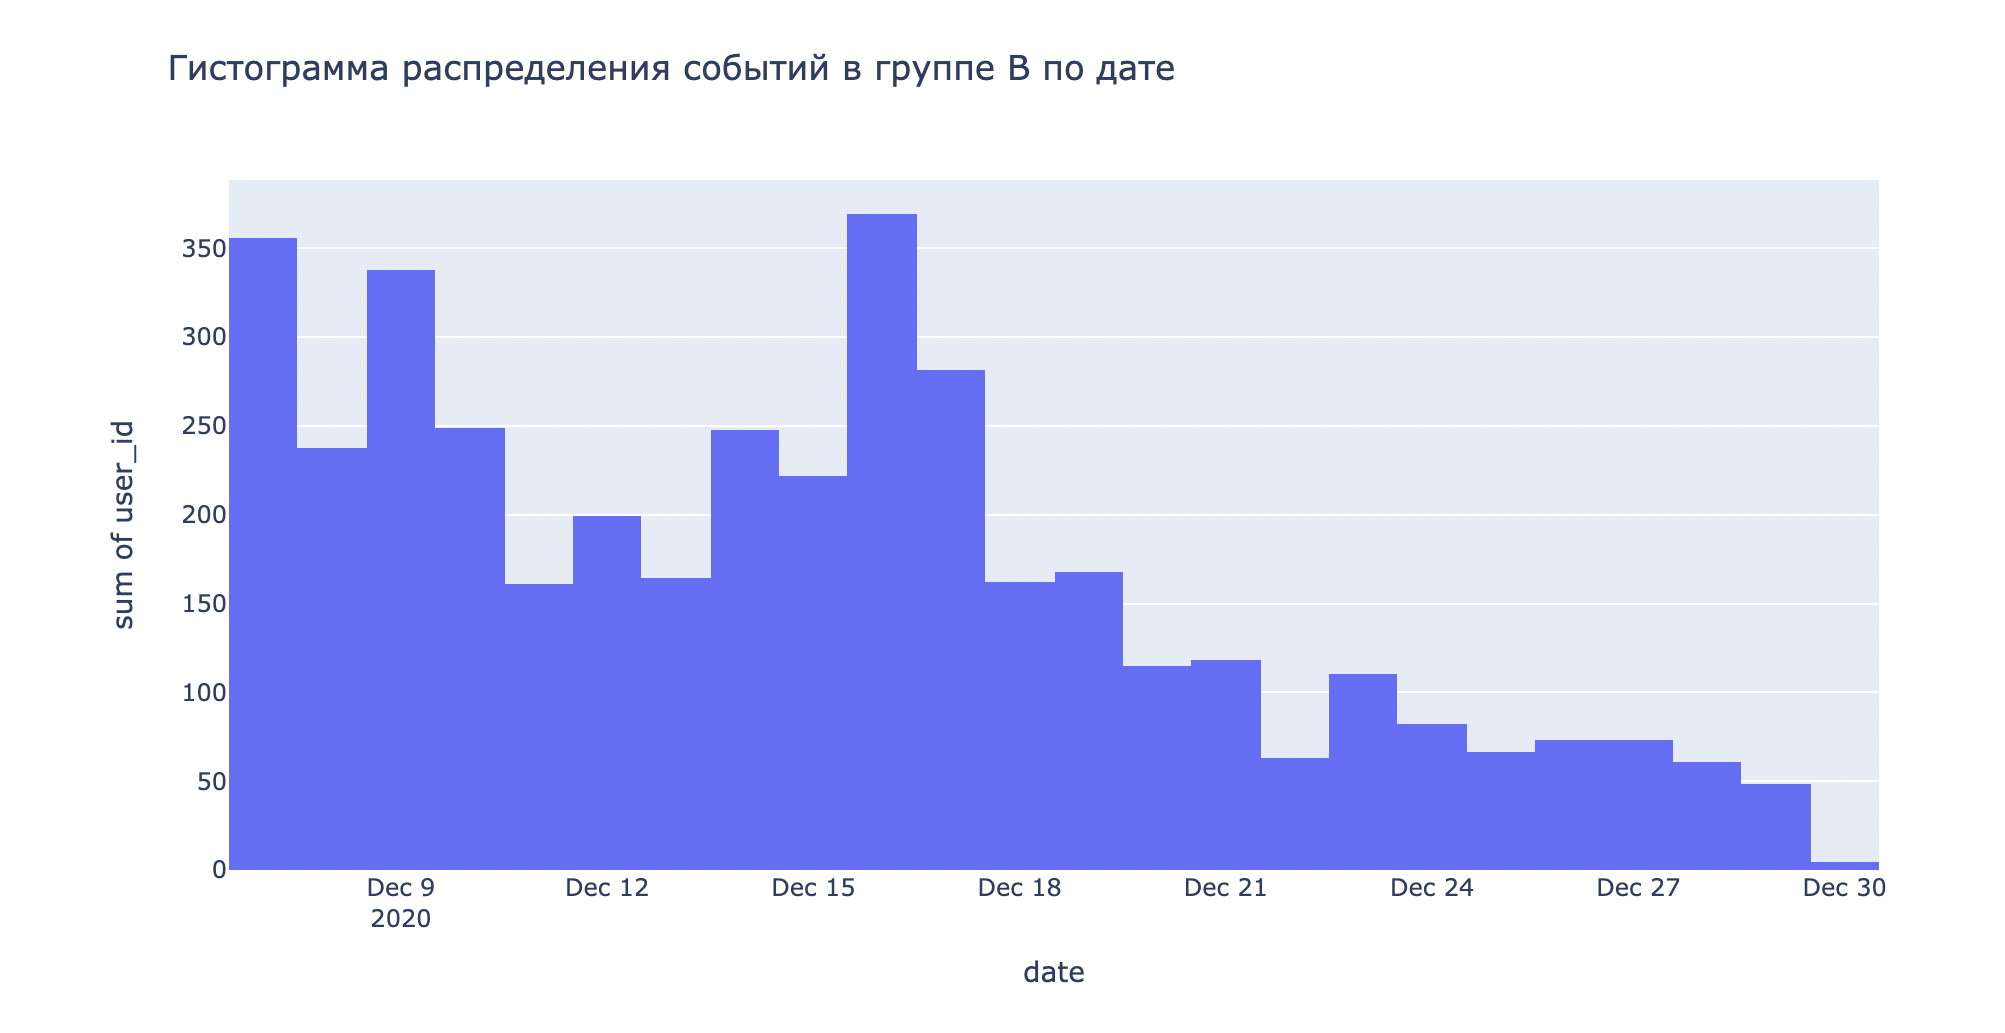

#### медианные значения: 531 в группе А и и 161,5 в группе В, но если учесть, что пользователей в контрольной группе больше в 2,3 раза, то показатели выглядят похожими на правду. Также в группе А можно было наблюдать большой всплеск активности с 14 по 19 декабря, а в группе В активность распределилась более равномерно с всплесками с 7 по 10 и с 14 по 17 декабря, в обоих группах активность пошла на спад, начиная с 21 декабря, это может быть обусловлено близостью Рождества.

### Как меняется конверсия в воронке в выборках на разных этапах?

In [41]:
funnel_a = (events_good_filtered[events_good_filtered['group'] == 'A']
            .groupby('event_name', as_index=False). agg({'user_id': 'nunique'})
                  .sort_values(by='user_id', ascending=False))
funnel_a['ratio'] = funnel_a['user_id'] / events_good_filtered[events_good_filtered['group'] == 'A']['user_id'].nunique()
funnel_a = funnel_a.reindex([0, 2, 1, 3])
funnel_a

event_name  user_id     ratio
0         login     1515  1.000000
2  product_page      962  0.634983
1  product_cart      458  0.302310
3      purchase      462  0.304950

In [42]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = list(funnel_a['event_name']),
    x = list(funnel_a['user_id']),
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.update_layout(title='Воронка для группы А')
fig.show()

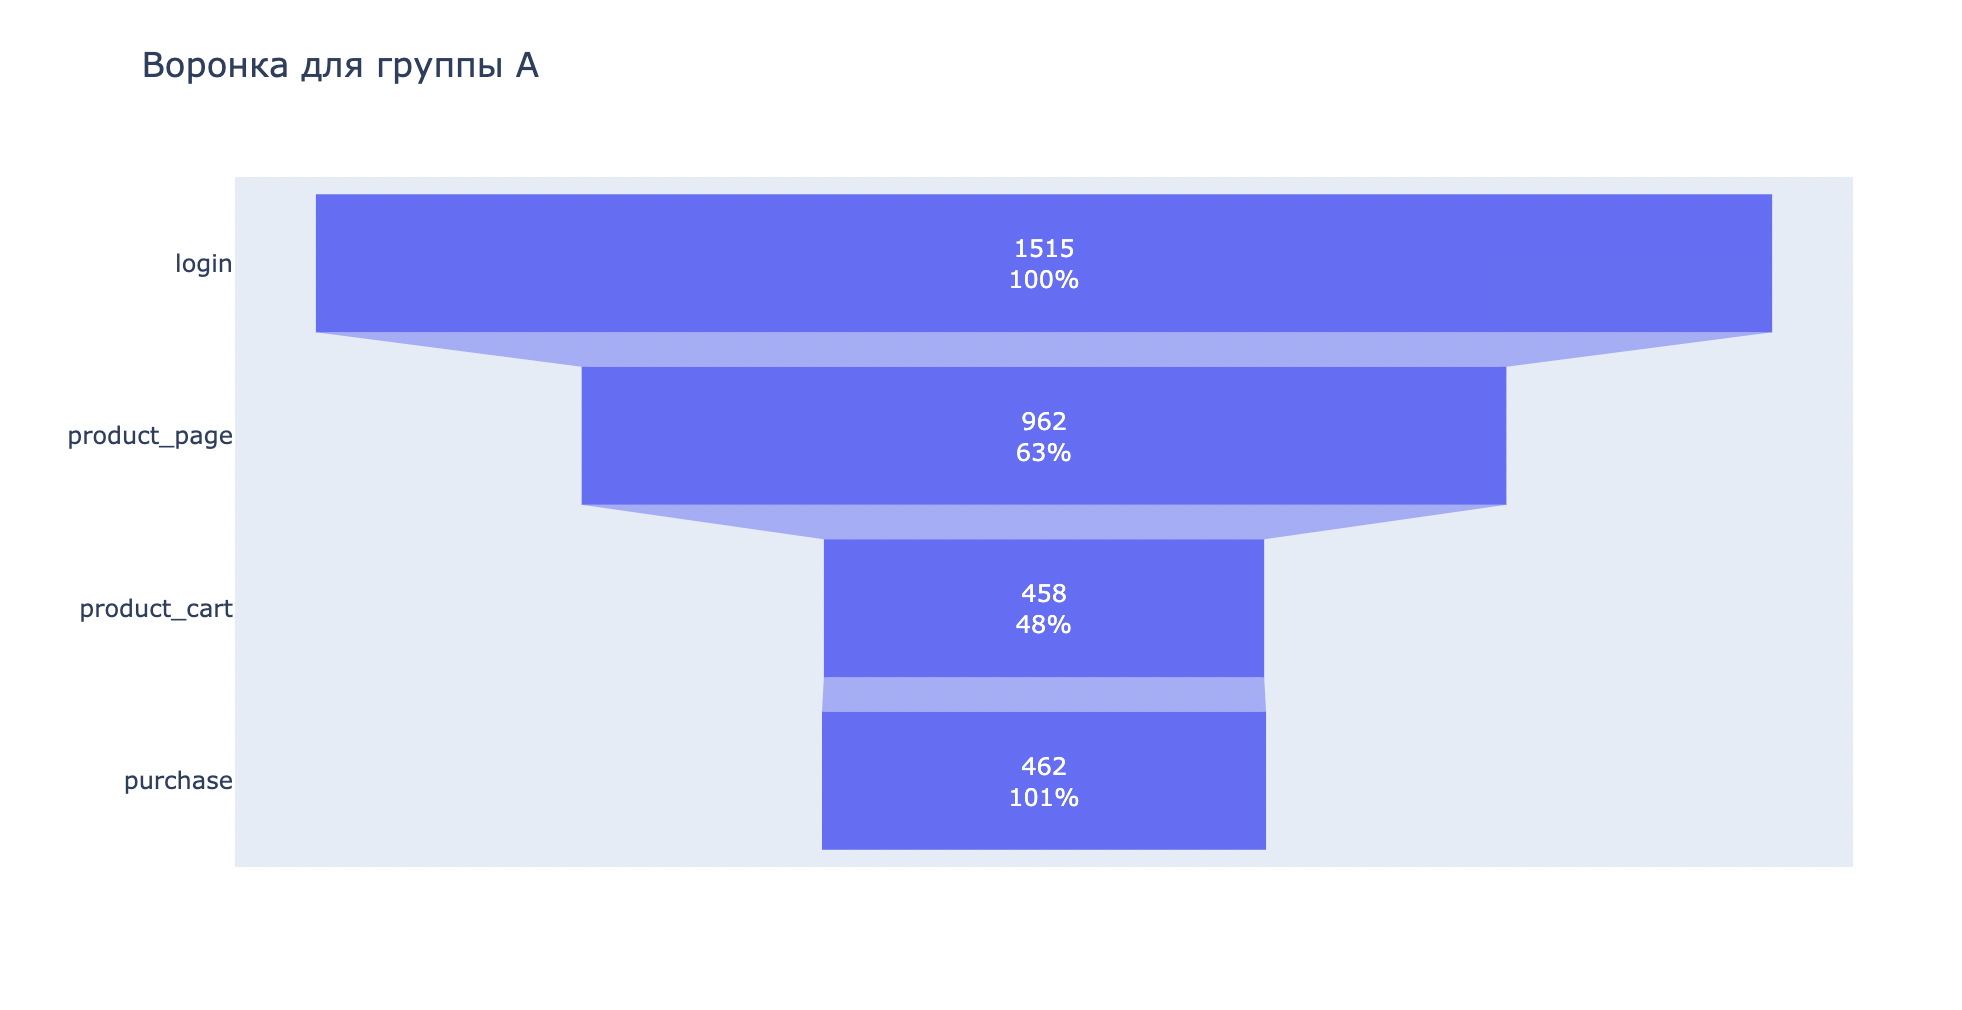

#### Вывод: 63% пользователей переходят на страницу с товаром, далее около половины от перешедших на страницу товара добавляют его в корзину, конверсия в покупки 101% - это, я полагаю, что есть возможность покупки сразу со страницы товара, не добавляя его в корзину.

In [43]:
funnel_b = (events_good_filtered[events_good_filtered['group'] == 'B']
            .groupby('event_name', as_index=False). agg({'user_id': 'nunique'})
                  .sort_values(by='user_id', ascending=False))
funnel_b['ratio'] = funnel_b['user_id'] / events_good_filtered[events_good_filtered['group'] == 'B']['user_id'].nunique()
funnel_b

event_name  user_id     ratio
0         login      640  1.000000
2  product_page      365  0.570312
1  product_cart      187  0.292187
3      purchase      183  0.285938

In [44]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = list(funnel_b['event_name']),
    x = list(funnel_b['user_id']),
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.update_layout(title='Воронка для группы B')
fig.show()

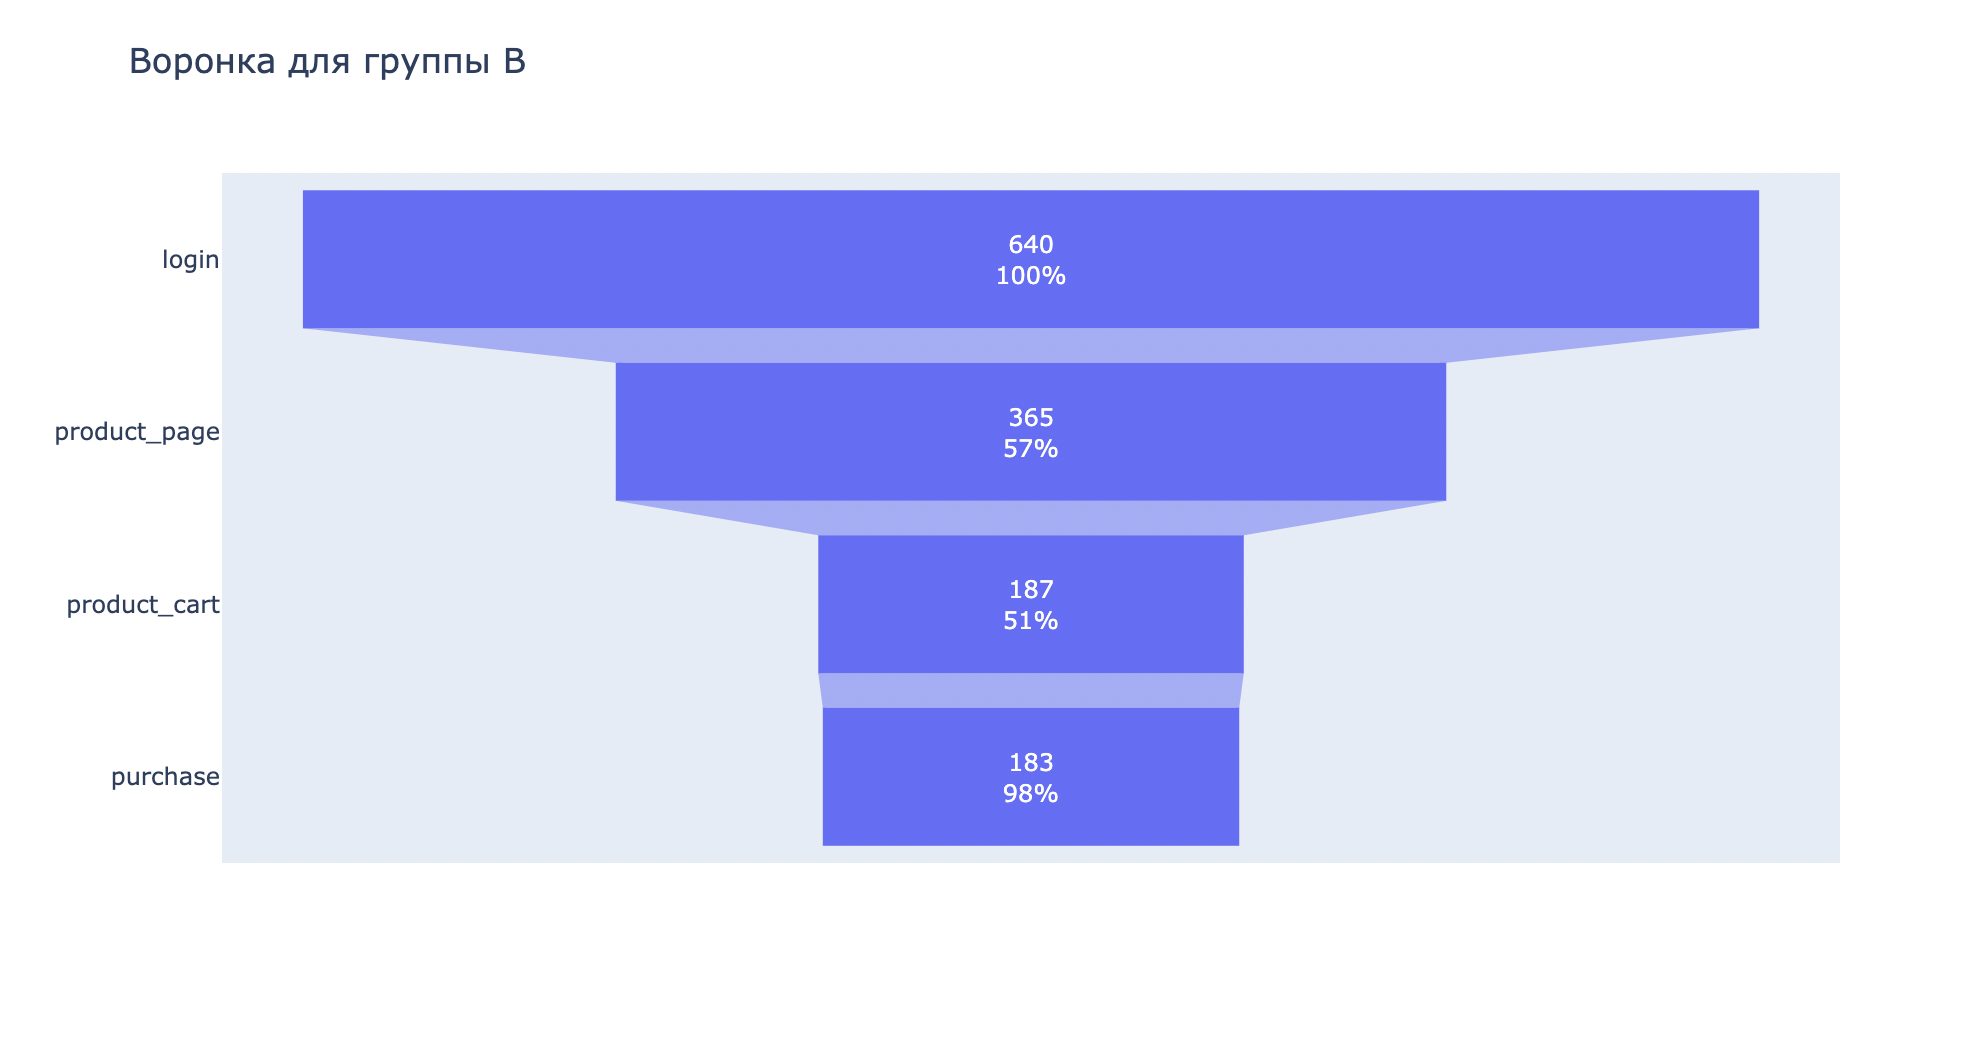

#### В группе В дела обстоят хуже, только 57% конвертируются в просмотр страницы товара, но зато в корзину его добавляет уже 51%, из них 98% уже конвертируются в покупку.

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

### Что касается данных и теста:
- во-первых все наши тестируемые уже принимают участие в другом тесте, да возможно влияние на обе группы одинаковое, учитывая распределение участников группы В второго теста по нашим группам, но все же.
- во-вторых тестирование попало на проведение промо акции, тут мы тоже предположили, что влияние акции имело сопоставимый эффект на всех участников теста, но мы не можем сказать это наверняка.
- ошибки в отборе- в наш тест попали пользователи из других регионов, коих оказалось около 5% от ввсех испытуемых.
- горизонт событий 14 дней согласно ТЗ слишком большой, большая часть пользователей была отсечена, тк последние события в логах датированы 30.12.2020, и многие пользователи просто не прожили этот цикл.
- разность размера групп: контрольная группа значительно больше группы с новой платежной воронкой.

## Изучим результаты эксперимента

In [45]:
users_total = events_good_filtered.pivot_table(index='group', values='user_id', aggfunc='nunique').T
users_total.columns = ['A', 'B']
users_total

A    B
user_id  1515  640

In [46]:
grouped_data = events_good_filtered.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
grouped_data.columns = ['A', 'B']
grouped_data = grouped_data.sort_values(by='B',ascending=False).reset_index()
grouped_data

event_name     A    B
0         login  1515  640
1  product_page   962  365
2  product_cart   458  187
3      purchase   462  183

#### Функция для проверки статистически значимой разницы между группами.

In [47]:
alpha = .05

In [48]:
def get_stats(event, group_1, group_2):
    successes = np.array([grouped_data[grouped_data['event_name'] == event][group_1],
                          grouped_data[grouped_data['event_name'] == event][group_2]])
    trials = np.array([users_total[group_1], users_total[group_2]])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 

    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

### Гипотезы:
- нулевая гипотеза: между долями нет разницы
- альтернативная гипотеза: между долями есть разница

#### Напишем цикл для проверки

In [49]:
events = ['product_page', 'product_cart', 'purchase']
for event in events:
    print(event)
    get_stats(event, 'A', 'B')

product_page
p-значение:  [0.00479947]
Отвергаем нулевую гипотезу: между долями есть значимая разница
product_cart
p-значение:  [0.63916498]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
purchase
p-значение:  [0.3785086]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Итак, согласно проведенному исследованию можно сказать что статистически значимая разница есть только на этапе конверсии в страницу продукта, да и то, судя по данным не в пользу группы с новой платежной воронкой, на остальных же этапах статистически значимой разницы не обнаружено. 

# ВЫВОД:
- мы загрузили данные проверили на пропуски, дубликаты, и типы. Пропуски у нас были только в таблице с событиями, да и те связаны с тем, что это детализация суммы покупки, в любом случае для анализ воронки они нам не нужны.
- мы обнаружили, что наш тест пересекается с одной промоакцией, но решили оставить все как есть, тк есть предположение, что она имеет одинаковый эффект на всех участников теста, тк она распространяется на всех пользователей EU.
- далее мы обнаружили, что все пользователи нашего теста параллельно принимают участие в другом тесте. Таким образом, чтобы оценить влияние, мы отфильтровали пользователей группы В второго теста и посмотрели как они распределились по группам в нашем тесте. В итоге выявили 783 участника группы В второго теста, попали в наш тест, а это около 11%, поэтому решили их оставить, тк они равномерно распределились по нашим группам, и предположительно влияние будет одинаковым для обеих групп. Можно было бы их отсечь, но это довольно значительное количество.
- далее мы подогнали данные под требования ТЗ. Мы отфильтровали участников не из Европы, которые случайно к нам попали. Затем мы проверили максимальные время и дату событий в нашей таблице - ей оказалось 30.12.2020 вместо 04.01.2021. таким образом на пришлось отсечь еще часть пользователей, которые не успели прожить 14 дней (Согласно ТЗ)
- затем мы проаналаизировали число событий на пользователя в обеих выборках, получилось, что в среднее кол-во событий на пользователя группы А на 15% больше, хотя медианные значения равны 6 в обеих группах, что говорит о том, что в группе А есть Аномально активные пользователи.
- далее мы посмотрели на распределение событий по дням в группах. медианные значения: 531 в группе А и и 161,5 в группе В, но если учесть, что пользователей в контрольной группе больше в 2,3 раза, то показатели выглядят похожими на правду. Также в группе А можно было наблюдать большой всплеск активности с 14 по 19 декабря, а в группе В активность распределилась более равномерно с всплесками с 7 по 10 и с 14 по 17 декабря, в обоих группах активность пошла на спад, начиная с 21 декабря, это может быть обусловлено близостью Рождества. 
- далее мы проанализировали конверсию в обоих группах: 63% в группе А против 57% в группе В проходили на страницу товара, далее в корзину товар добавляли 48% в группе А против 51% в группе В, из корзины покупку же совершали 101% в группе А и 98% в группе В. 101% связан скорее всего с тем, что товар можно купить не добавляя его в корзину, а прямо со страницы товара.
- что же касается результатов эксперимента, то статистически значимую разницу мы обнаружили только на этапе перехода на страницу товара, да и та не в пользу группы В, на остальных же этапах статистически значимой разницы не обнаружено.

#### В итоге счтиаю тест не очень корректным, тк его проводили в рождественский период, когда поведение пользователей сильно отличается от обычного, еще и промоакция наложила свой эффект. В ТЗ заявили большой горизонт событий в 14 дней, можно попробовать более короткий. Пересечение с другим тестом не беру в расчет, тк считаю, что влияние все-таки равномерное.